# Validation and Verification of the 15mm collimator simulation, GP3, PhSF

Here we provide code and output which verifies and validates the 15mm collimator simulation. We're using simulation phase space file output and input to check the validity of the result. Geometry of the source is 12mm in length and activity of 120Ci.

In [1]:
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import BEAMphsf

import beam_loader
import H1Dn
import H1Du
import ListTable

%matplotlib inline

In [2]:
def cm2mm(value):
    """
    converts cm to mm
    """
    return value*10.0

*First, set filename to what we want to examine and read PhSF header*

In [3]:
C = 15
phsfname = "C" + str(C) + "GP3" + ".egsphsp1"
phsfname = "../" + phsfname
print ("We're reading the {1}mm phase space file = {0}".format(phsfname, C))

We're reading the 15mm phase space file = ../C15GP3.egsphsp1


*Checking PhSF header parameters*

In [4]:
m, NPPHSP, NPHOTPHSP, EKMAX, EKMIN, NINCP = beam_loader.read_header_byname(phsfname)
print ("We're reading the {1}mm phase space file = {0}".format(phsfname, C))
if m == beam_loader.SHORT:
    print("We have short MODE0 phase space file".format(m))
elif m == beam_loader.LONG:
    print("We have long MODE2 phase space file".format(m))
    
print("Total nof of particle records: {0}".format(NPPHSP))
print("Total nof of photon records: {0}".format(NPHOTPHSP))
print("Maximum kinetic energy: {0} MeV".format(EKMAX))
print("Minimum kinetic energy: {0} MeV".format(EKMIN))
print("Number of original particles: {0}".format(NINCP))
print("Yield: {0}".format(NPHOTPHSP/NINCP))

We're reading the 15mm phase space file = ../C15GP3.egsphsp1
We have long MODE2 phase space file
Total nof of particle records: 4438565
Total nof of photon records: 4438565
Maximum kinetic energy: 1.3300000429153442 MeV
Minimum kinetic energy: 0.002594300080090761 MeV
Number of original particles: 40000000000.0
Yield: 0.000110964125


In [5]:
events, nof_photons, nof_electrons, nof_positrons = beam_loader.load_events(phsfname, -1)

print("Number of loaded events: {0}".format(len(events)))
print("Number of loaded photons: {0}".format(nof_photons))
print("Number of loaded electrons: {0}".format(nof_electrons))
print("Number of loaded positrons: {0}".format(nof_positrons))

Number of loaded events: 4438565
Number of loaded photons: 4438565
Number of loaded electrons: 0
Number of loaded positrons: 0


Convert all spatial coordinates to mm

In [6]:
evts = list()
for event in events:
    wt = event[0]
    e  = event[1]
    x  = cm2mm(event[2])
    y  = cm2mm(event[3])
    zl = cm2mm(event[4])
    wx = event[5]
    wy = event[6]
    wz = event[7]
    
    evts.append(((wt, e, x, y, zl, wx, wy, wz)))
    
events = evts

## Energy Spectrum tests

*We expect energy spectrum to be scattering background together with peaks δ(E-1.17) and δ(E-1.33). Below we'trying to prove this statement. We will draw the distributions and histograms to estimate influence of the background scattering and get the data about δ-peaks*

### We're filling energy histogram now, basic checks

*We're building scale with 5 bins in the region between 1.17 and 1.33 MeV, all other bins below 1.17 are of about the same size as those 5*

In [7]:
# make scale with explicit bins at 1.17 MeV and 1.33 MeV
nbins = 5

scale = BEAMphsf.make_energy_scale(nbins, lo = 0.01, me = 1.1700001, hi = 1.3300001)

he = H1Dn.H1Dn(scale)

for e in events:
    WT = e[0]
    E  = e[1]
    he.fill(E, WT)
    
print("Number of events in histogram: {0}".format(he.nof_events()))
print("Integral in histogram: {0}".format(he.integral()))
print("Underflow bin: {0}".format(he.underflow()))
print("Overflow  bin: {0}".format(he.overflow()))

Number of events in histogram: 4438565
Integral in histogram: 4438565.0
Underflow bin: (73.0, 73, 73.0)
Overflow  bin: (0.0, 0, 0.0)


*Underflow bin is close to empty, as well as Overflow bin. This is good because we do not expect events beyond 1.33MeV and below ECUT*

### Drawing Probability Density Function for 5 bins between 1.33 peak and 1.17 peak.

PDF normalization: 0.9999999999999999


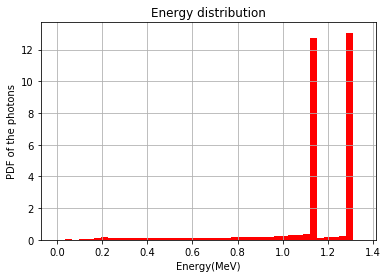

In [8]:
X = []
Y = []
W = []

scale = he.x()
n     = len(scale)
norm  = 1.0/he.integral()

sum = 0.0

for k in range (-1, he.size()+1):
    x = 0.0
    w = (he.lo() - x)
    if k == he.size():
        w = (scale[-1]-scale[-2])
        x = he.hi()
    elif k >= 0:
        w = (scale[k+1] - scale[k])
        x = scale[k]

    d = he[k]     # data from bin with index k
    y = d[0] / w  # first part of bin is collected weights
    y = y * norm
    X.append(x)
    Y.append(y)
    W.append(w)
    sum += y*w

print("PDF normalization: {0}".format(sum))

E133_5 = Y[-2]
E117_5 = Y[-2-nbins]

p1 = plt.bar(X, Y, W, color='r')

plt.xlabel('Energy(MeV)')
plt.ylabel('PDF of the photons')
plt.title('Energy distribution')

plt.grid(True);
plt.tick_params(axis='x', direction='out')
plt.tick_params(axis='y', direction='out')

plt.show()

In [9]:
# saving peak values
print("Peak PDF value at 1.33 MeV: {0}".format(E133_5))
print("Peak PDF value at 1.17 MeV: {0}".format(E117_5))

Peak PDF value at 1.33 MeV: 13.060717540466333
Peak PDF value at 1.17 MeV: 12.713976814578574


### Filling energy histogram with double number of bins

*We're building scale with 10 bins in the region between 1.17 and 1.33 MeV, all other bins below 1.17 are of about the same size as those 10*

In [10]:
# make scale with explicit bins at 1.17 MeV and 1.33 MeV
nbins = 10

scale = BEAMphsf.make_energy_scale(nbins, lo = 0.01, me = 1.1700001, hi = 1.3300001)

he = H1Dn.H1Dn(scale)

for e in events:
    WT = e[0]
    E  = e[1]
    he.fill(E, WT)
    
print("Number of events in histogram: {0}".format(he.nof_events()))
print("Integral in histogram: {0}".format(he.integral()))
print("Underflow bin: {0}".format(he.underflow()))
print("Overflow  bin: {0}".format(he.overflow()))

Number of events in histogram: 4438565
Integral in histogram: 4438565.0
Underflow bin: (73.0, 73, 73.0)
Overflow  bin: (0.0, 0, 0.0)


*Underflow bin is close to empty, as well as Overflow bin. This is good because we do not expect events beyond 1.33MeV and below ECUT*

### Drawing Probability Density Function for 10 bins between 1.33 peak and 1.17 peak.

PDF normalization: 0.9999999999999999


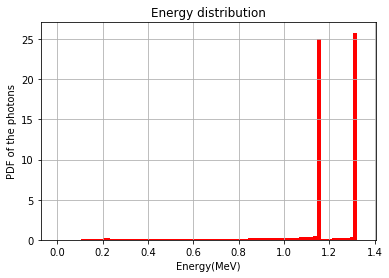

In [11]:
X = []
Y = []
W = []

scale = he.x()
n     = len(scale)
norm  = 1.0/he.integral()

sum = 0.0

for k in range (-1, he.size()+1):
    x = 0.0
    w = (he.lo() - x)
    if k == he.size():
        w = (scale[-1]-scale[-2])
        x = he.hi()
    elif k >= 0:
        w = (scale[k+1] - scale[k])
        x = scale[k]

    d = he[k]     # data from bin with index k
    y = d[0] / w  # first part of bin is collected weights
    y = y * norm
    X.append(x)
    Y.append(y)
    W.append(w)
    sum += y*w

print("PDF normalization: {0}".format(sum))

E133_10 = Y[-2]
E117_10 = Y[-2-nbins]

p1 = plt.bar(X, Y, W, color='r')

plt.xlabel('Energy(MeV)')
plt.ylabel('PDF of the photons')
plt.title('Energy distribution')

plt.grid(True);
plt.tick_params(axis='x', direction='out')
plt.tick_params(axis='y', direction='out')

plt.show()

In [12]:
# saving peak values
print("Peak PDF value at 1.33 MeV: {0}".format(E133_10))
print("Peak PDF value at 1.17 MeV: {0}".format(E117_10))

Peak PDF value at 1.33 MeV: 25.81597318052116
Peak PDF value at 1.17 MeV: 24.979244417959386


### Filling energy histogram with quadruple number of bins

*We're building scale with 20 bins in the region between 1.17 and 1.33 MeV, all other bins below 1.17 are of about the same size as those 20.*

In [13]:
# make scale with explicit bins at 1.17 MeV and 1.33 MeV
nbins = 20

scale = BEAMphsf.make_energy_scale(nbins, lo = 0.01, me = 1.1700001, hi = 1.3300001)

he = H1Dn.H1Dn(scale)

for e in events:
    WT = e[0]
    E  = e[1]
    he.fill(E, WT)
    
print("Number of events in histogram: {0}".format(he.nof_events()))
print("Integral in histogram: {0}".format(he.integral()))
print("Underflow bin: {0}".format(he.underflow()))
print("Overflow  bin: {0}".format(he.overflow()))

Number of events in histogram: 4438565
Integral in histogram: 4438565.0
Underflow bin: (73.0, 73, 73.0)
Overflow  bin: (0.0, 0, 0.0)


*Underflow bin is close to empty, as well as Overflow bin. This is good because we do not expect events beyond 1.33MeV and below ECUT*

### Drawing Probability Density Function for 10 bins between 1.33 peak and 1.17 peak.

PDF normalization: 1.0000000000000002


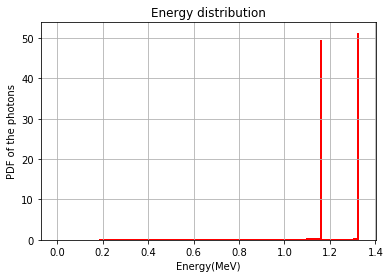

In [14]:
X = []
Y = []
W = []

scale = he.x()
n     = len(scale)
norm  = 1.0/he.integral()

sum = 0.0

for k in range (-1, he.size()+1):
    x = 0.0
    w = (he.lo() - x)
    if k == he.size():
        w = (scale[-1]-scale[-2])
        x = he.hi()
    elif k >= 0:
        w = (scale[k+1] - scale[k])
        x = scale[k]

    d = he[k]     # data from bin with index k
    y = d[0] / w  # first part of bin is collected weights
    y = y * norm
    X.append(x)
    Y.append(y)
    W.append(w)
    sum += y*w

print("PDF normalization: {0}".format(sum))

E133_20 = Y[-2]
E117_20 = Y[-2-nbins]

p1 = plt.bar(X, Y, W, color='r')

plt.xlabel('Energy(MeV)')
plt.ylabel('PDF of the photons')
plt.title('Energy distribution')

plt.grid(True);
plt.tick_params(axis='x', direction='out')
plt.tick_params(axis='y', direction='out')

plt.show()

In [15]:
# saving peak values
print("Peak PDF value at 1.33 MeV: {0}".format(E133_20))
print("Peak PDF value at 1.17 MeV: {0}".format(E117_20))

Peak PDF value at 1.33 MeV: 51.30016683319943
Peak PDF value at 1.17 MeV: 49.434530078978185


### Comparing peak values

*We would compare peak values at 10 bins and at 5 bins. The presence of δ-peaks means that with doubling number of bins we shall expect the roughly doubling the peak values.*

In [16]:
table = ListTable.ListTable()

table.append(["Nbins", "E=1.17", "E=1.33"])
table.append(["", "MeV", "MeV"])
table.append([5, 1.0, 1.0])
table.append([10, E133_10/E133_5, E133_10/E133_5])
table.append([20, E133_20/E133_5, E133_20/E133_5])
table

Nbins,E=1.17,E=1.33
,MeV,MeV
5,1.0,1.0
10,1.9766121654905187,1.9766121654905187
20,3.927821474911688,3.927821474911688


*The result is as expected. Only few percent of the values in the 1.33 and 1.17 MeV bins are due to scattered radiation. Most values are coming from primary source and are δ-peaks in energy.*

## Spatial Distribution tests

*Here we will plot spatial distribution of the particles, projected from collimator exit position to the isocenter location at 38cm*

In [17]:
Znow  = 200.0 # we at 000mm at the cooolimator exit
Zshot = 360.0 # shot isocenter is at 380mm

# radial, X and Y, all units in mm
hr = H1Du.H1Du(120, 0.0, 40.0)
hx = H1Du.H1Du(128, -32.0, 32.0)
hy = H1Du.H1Du(128, -32.0, 32.0)

for e in events:
    WT = e[0]
    xx, yy, zz = BEAMphsf.move_event(e, Znow, Zshot)
    
    #xx = e[2]
    #yy = e[3]
    #zz = e[4]
    
    r = math.sqrt(xx*xx + yy*yy)
    hr.fill(r, WT)
    hx.fill(xx, WT)
    hy.fill(yy, WT)

print("Number of events in R histogram: {0}".format(hr.nof_events()))
print("Integral in R histogram: {0}".format(hr.integral()))
print("Underflow bin: {0}".format(hr.underflow()))
print("Overflow  bin: {0}\n".format(hr.overflow()))

print("Number of events in X histogram: {0}".format(hx.nof_events()))
print("Integral in X histogram: {0}".format(hx.integral()))
print("Underflow bin: {0}".format(hx.underflow()))
print("Overflow  bin: {0}\n".format(hx.overflow()))

print("Number of events in Y histogram: {0}".format(hy.nof_events()))
print("Integral in Y histogram: {0}".format(hy.integral()))
print("Underflow bin: {0}".format(hy.underflow()))
print("Overflow  bin: {0}".format(hy.overflow()))

Number of events in R histogram: 4438565
Integral in R histogram: 4438565.0
Underflow bin: (0.0, 0, 0.0)
Overflow  bin: (139547.0, 139547, 139547.0)

Number of events in X histogram: 4438565
Integral in X histogram: 4438565.0
Underflow bin: (53839.0, 53839, 53839.0)
Overflow  bin: (53837.0, 53837, 53837.0)

Number of events in Y histogram: 4438565
Integral in Y histogram: 4438565.0
Underflow bin: (53718.0, 53718, 53718.0)
Overflow  bin: (53874.0, 53874, 53874.0)


PDF normalization: 1.0


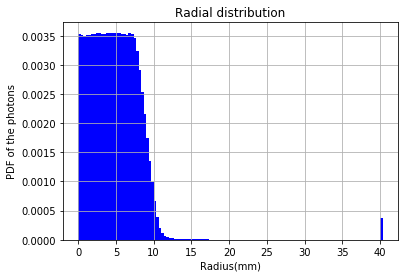

In [18]:
X = []
Y = []
W = []

norm  = 1.0/hr.integral()

sum = 0.0

st = hr.step()

for k in range (0, hr.size()+1):
    r_lo = hr.lo() + float(k) * st
    r_hi = r_lo + st
    r = 0.5*(r_lo + r_hi)
    
    ba = math.pi * (r_hi*r_hi - r_lo*r_lo) # bin area

    d = hr[k]      # data from bin with index k
    y = d[0] / ba  # first part of bin is collected weights
    y = y * norm
    X.append(r)
    Y.append(y)
    W.append(st)
    sum += y * ba

print("PDF normalization: {0}".format(sum))

p1 = plt.bar(X, Y, W, 0.0, color='b')

plt.xlabel('Radius(mm)')
plt.ylabel('PDF of the photons')
plt.title('Radial distribution')

plt.grid(True);
plt.tick_params(axis='x', direction='out')
plt.tick_params(axis='y', direction='out')

plt.show()

NB: peak at the far right above 40mm is overflow bin

PDF normalization: 0.9757408081215434


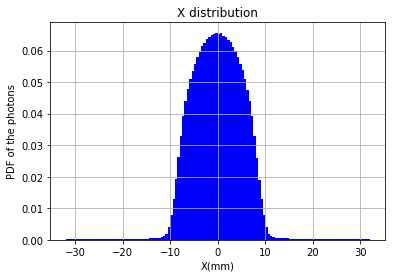

In [19]:
X = []
Y = []
W = []

norm  = 1.0/hx.integral()

sum = 0.0

st = hx.step()    

for k in range (0, hx.size()):
    x_lo = hx.lo() + float(k)*st
    x_hi = x_lo + st
    x    = 0.5*(x_lo + x_hi)

    d = hx[k]        # data from bin with index k
    y = d[0] / st    # first part of bin is collected weights
    y = y * norm
    X.append(x)
    Y.append(y)
    W.append(st)
    sum += y*st

print("PDF normalization: {0}".format(sum))

p1 = plt.bar(X, Y, W, color='b')

plt.xlabel('X(mm)')
plt.ylabel('PDF of the photons')
plt.title('X distribution')

plt.grid(True);
plt.tick_params(axis='x', direction='out')
plt.tick_params(axis='y', direction='out')

plt.show()

PDF normalization: 0.9757597331569998


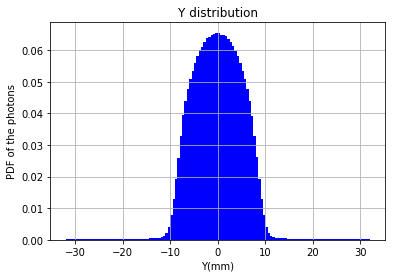

In [20]:
X = []
Y = []
W = []

norm  = 1.0/hy.integral()

sum = 0.0

st = hy.step()

for k in range (0, hy.size()):
    x_lo = hy.lo() + float(k)*st
    x_hi = x_lo + st
    x    = 0.5*(x_lo + x_hi)

    d = hy[k]       # data from bin with index k
    y = d[0] / st    # first part of bin is collected weights
    y = y * norm
    X.append(x)
    Y.append(y)
    W.append(st)
    sum += y*st

print("PDF normalization: {0}".format(sum))

p1 = plt.bar(X, Y, W, color='b')

plt.xlabel('Y(mm)')
plt.ylabel('PDF of the photons')
plt.title('Y distribution')

plt.grid(True);
plt.tick_params(axis='x', direction='out')
plt.tick_params(axis='y', direction='out')

plt.show()

*We find spatial distribution to be consistent with the collimation setup*

## Angular Distribution tests

*Here we plot particles angular distribution for all three directional cosines, at the collimator exit. We expect angular distribution to fill collimation angle which is close to 0.017 radians (0.5x15/380).*

In [21]:
# angular, WZ, WX and WY, all units in radians
h_wz = H1Du.H1Du(100, 1.0 - 0.05, 1.0)
h_wx = H1Du.H1Du(110, -0.055, 0.055)
h_wy = H1Du.H1Du(110, -0.055, 0.055)

for e in events:
    WT = e[0]
    
    wx = e[5]
    wy = e[6]
    wz = e[7]
    
    h_wz.fill(wz, WT)
    h_wx.fill(wx, WT)
    h_wy.fill(wy, WT)

print("Number of events in WZ histogram: {0}".format(h_wz.nof_events()))
print("Integral in WZ histogram: {0}".format(h_wz.integral()))
print("Underflow bin: {0}".format(h_wz.underflow()))
print("Overflow  bin: {0}\n".format(h_wz.overflow()))

print("Number of events in WX histogram: {0}".format(h_wx.nof_events()))
print("Integral in WX histogram: {0}".format(h_wx.integral()))
print("Underflow bin: {0}".format(h_wx.underflow()))
print("Overflow  bin: {0}\n".format(h_wx.overflow()))

print("Number of events in WY histogram: {0}".format(h_wy.nof_events()))
print("Integral in WY histogram: {0}".format(h_wy.integral()))
print("Underflow bin: {0}".format(h_wy.underflow()))
print("Overflow  bin: {0}".format(h_wy.overflow()))

Number of events in WZ histogram: 4438565
Integral in WZ histogram: 4438565.0
Underflow bin: (107140.0, 107140, 107140.0)
Overflow  bin: (0.0, 0, 0.0)

Number of events in WX histogram: 4438565
Integral in WX histogram: 4438565.0
Underflow bin: (82137.0, 82137, 82137.0)
Overflow  bin: (82010.0, 82010, 82010.0)

Number of events in WY histogram: 4438565
Integral in WY histogram: 4438565.0
Underflow bin: (82052.0, 82052, 82052.0)
Overflow  bin: (82142.0, 82142, 82142.0)


PDF normalization: 0.9758615678715982


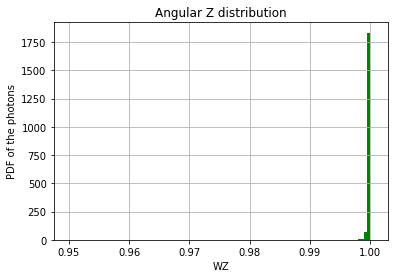

In [22]:
X = []
Y = []
W = []

norm  = 1.0/h_wz.integral()

sum = 0.0

st = h_wz.step()

for k in range (0, h_wz.size()+1):
    x_lo = h_wz.lo() + float(k)*st
    x_hi = x_lo + st
    x    = 0.5*(x_lo + x_hi)

    d = h_wz[k]       # data from bin with index k
    y = d[0] / st     # first part of bin is collected weights
    y = y * norm
    X.append(x)
    Y.append(y)
    W.append(st)
    sum += y*st

print("PDF normalization: {0}".format(sum))

p1 = plt.bar(X, Y, W, color='g')

plt.xlabel('WZ')
plt.ylabel('PDF of the photons')
plt.title('Angular Z distribution')

plt.grid(True);
plt.tick_params(axis='x', direction='out')
plt.tick_params(axis='y', direction='out')

plt.show()

PDF normalization: 0.9630180024399779


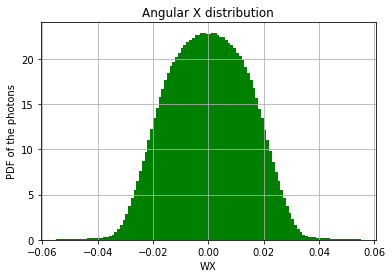

In [23]:
X = []
Y = []
W = []

norm  = 1.0/h_wx.integral()

sum = 0.0

st = h_wx.step()

for k in range (0, h_wx.size()):
    x_lo = h_wx.lo() + float(k)*st
    x_hi = x_lo + st
    x    = 0.5*(x_lo + x_hi)

    d = h_wx[k]       # data from bin with index k
    y = d[0] / st     # first part of bin is collected weights
    y = y * norm
    X.append(x)
    Y.append(y)
    W.append(st)
    sum += y*st

print("PDF normalization: {0}".format(sum))

p1 = plt.bar(X, Y, W, color='g')

plt.xlabel('WX')
plt.ylabel('PDF of the photons')
plt.title('Angular X distribution')

plt.grid(True);
plt.tick_params(axis='x', direction='out')
plt.tick_params(axis='y', direction='out')

plt.show()

PDF normalization: 0.9630074134320437


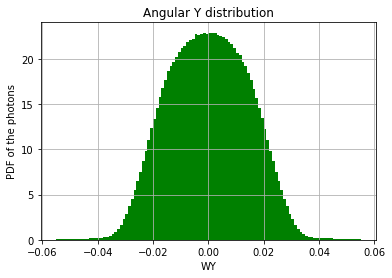

In [24]:
X = []
Y = []
W = []

norm  = 1.0/h_wy.integral()

sum = 0.0

st = h_wy.step()

for k in range (0, h_wy.size()):
    x_lo = h_wy.lo() + float(k)*st
    x_hi = x_lo + st
    x    = 0.5*(x_lo + x_hi)

    d = h_wy[k]       # data from bin with index k
    y = d[0] / st     # first part of bin is collected weights
    y = y * norm
    X.append(x)
    Y.append(y)
    W.append(st)
    sum += y*st

print("PDF normalization: {0}".format(sum))

p1 = plt.bar(X, Y, W, color='g')

plt.xlabel('WY')
plt.ylabel('PDF of the photons')
plt.title('Angular Y distribution')

plt.grid(True);
plt.tick_params(axis='x', direction='out')
plt.tick_params(axis='y', direction='out')

plt.show()

*We find photon angular distribution to be consistent with the collimation setup*

## Conclusion

*After plotting and analyzing photons energy, spatial and angular distribution, we could conclude that it is consistent with simulation Co60 source, sending particles through collimation system of 15mm collimation spot at 360mm isocenter.*